<a href="https://colab.research.google.com/github/LucaLehigh/Lab-CSE337/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [6]:
def epsilon_greedy(state, epsilon):
  if random.random() < epsilon:
    return env.action_space.sample()
  # greedy action from network
  state_t = torch.FloatTensor(state).unsqueeze(0).to(device)    # shape (1, state_dim)
  with torch.no_grad():
    q_vals = q_net(state_t)   # (1, n_actions)
    action = torch.argmax(q_vals, dim=1).item()
  return int(action)

In [7]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/tmp/ipython-input-1929135722.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Episode 50/5000 | EpisodeReward: -2243.0 | AvgLast50: -7284.24 | Epsilon: 0.778 | ReplaySize: 50000
Episode 100/5000 | EpisodeReward: -479.0 | AvgLast50: -641.14 | Epsilon: 0.606 | ReplaySize: 50000
Episode 150/5000 | EpisodeReward: -272.0 | AvgLast50: -408.66 | Epsilon: 0.471 | ReplaySize: 50000
Episode 200/5000 | EpisodeReward: -209.0 | AvgLast50: -218.16 | Epsilon: 0.367 | ReplaySize: 50000
Episode 250/5000 | EpisodeReward: -187.0 | AvgLast50: -164.48 | Epsilon: 0.286 | ReplaySize: 50000
Episode 300/5000 | EpisodeReward: -152.0 | AvgLast50: -163.32 | Epsilon: 0.222 | ReplaySize: 50000
Episode 350/5000 | EpisodeReward: -119.0 | AvgLast50: -159.98 | Epsilon: 0.173 | ReplaySize: 50000
Episode 400/5000 | EpisodeReward: -159.0 | AvgLast50: -155.04 | Epsilon: 0.135 | ReplaySize: 50000
Episode 450/5000 | EpisodeReward: -117.0 | AvgLast50: -144.72 | Epsilon: 0.105 | ReplaySize: 50000
Episode 500/5000 | EpisodeReward: -200.0 | AvgLast50: -149.84 | Epsilon: 0.082 | ReplaySize: 50000
Episode 5

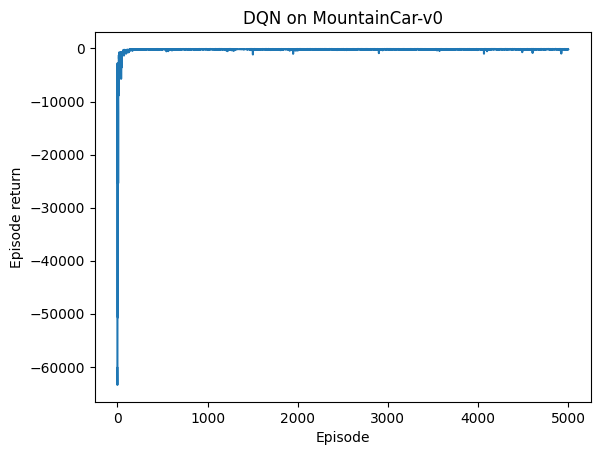

In [8]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0.0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        # store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, float(done)))

        # move to next state
        state = next_state
        total_reward += reward

        # perform a training step if enough samples available
        train_dqn()

    # end of episode bookkeeping
    rewards_dqn.append(total_reward)

    # decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # logging
    if (episode + 1) % 50 == 0:
        recent_avg = np.mean(rewards_dqn[-50:])
        print(f"Episode {episode+1}/{num_episodes} | "
              f"EpisodeReward: {total_reward:.1f} | "
              f"AvgLast50: {recent_avg:.2f} | "
              f"Epsilon: {epsilon:.3f} | ReplaySize: {len(replay_buffer)}")

# Optional: plot rewards
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Episode return")
plt.title("DQN on MountainCar-v0")
plt.show()


# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [15]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from typing import Tuple

# Set up environment
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n


# Hyperparameters
gamma = 0.99
lr = 1e-3
initial_epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 2000
batch_size = 64
replay_buffer_size = 100_000
target_update_freq = 1000
train_after = 1000
max_steps_per_episode = 1000
grad_clip = 10.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

QNetwork

In [16]:
class QNetwork(nn.Module):
  def __init__(self, state_dim:int, n_actions:int):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, n_actions)
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.net(x)

Replay Buffer

In [17]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def append(self, s, a, r, s_next, done):
        # store raw numpy / python types; convert when sampling
        self.buffer.append((s, a, r, s_next, float(done)))

    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)
        return states, actions, rewards, next_states, dones

Initialize QNetwork

In [18]:
q_net = QNetwork(state_dim, n_actions).to(device)
q_target = QNetwork(state_dim, n_actions).to(device)
q_target.load_state_dict(q_net.state_dict())
q_target.eval()

optimizer = optim.Adam(q_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

replay_buffer = ReplayBuffer(replay_buffer_size)

Epsilon Greedy

In [19]:
def epsilon_greedy(state: np.ndarray, epsilon: float) -> int:
  if random.random() < epsilon:
    return env.action_space.sample()
  state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
  with torch.no_grad():
    q_vals = q_net(state_t)   # (1, n_actions)
    action = int(torch.argmax(q_vals, dim=1).item())
  return action

In [20]:
def train_step(batch_size: int):
    if len(replay_buffer) < batch_size:
        return None
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Predicted Q for taken actions
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Target: r + gamma * max_a Q_target(next_state, a) * (1 - done)
    with torch.no_grad():
        next_q = q_target(next_states).max(1)[0]
        targets = rewards + gamma * next_q * (1.0 - dones)

    loss = loss_fn(q_values, targets)

    optimizer.zero_grad()
    loss.backward()
    # gradient clipping
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), grad_clip)
    optimizer.step()
    return loss.item()

Ep 10/2000 | EpReward -84.91 | AvgLast10 -97.74 | AvgLast100 -97.74 | Eps 0.951 | Replay 849
Ep 20/2000 | EpReward -431.14 | AvgLast10 -180.43 | AvgLast100 -139.08 | Eps 0.905 | Replay 1741
Ep 30/2000 | EpReward -108.04 | AvgLast10 -163.08 | AvgLast100 -147.08 | Eps 0.860 | Replay 2677
Ep 40/2000 | EpReward -160.29 | AvgLast10 -160.42 | AvgLast100 -150.42 | Eps 0.818 | Replay 3752
Ep 50/2000 | EpReward -164.18 | AvgLast10 -141.01 | AvgLast100 -148.54 | Eps 0.778 | Replay 4973
Ep 60/2000 | EpReward 5.99 | AvgLast10 -91.77 | AvgLast100 -139.07 | Eps 0.740 | Replay 6152
Ep 70/2000 | EpReward -45.18 | AvgLast10 -102.91 | AvgLast100 -133.91 | Eps 0.704 | Replay 7272
Ep 80/2000 | EpReward -99.96 | AvgLast10 -88.42 | AvgLast100 -128.22 | Eps 0.670 | Replay 8585
Ep 90/2000 | EpReward -124.13 | AvgLast10 -101.73 | AvgLast100 -125.28 | Eps 0.637 | Replay 10547
Ep 100/2000 | EpReward -71.04 | AvgLast10 -72.17 | AvgLast100 -119.97 | Eps 0.606 | Replay 14584
Ep 110/2000 | EpReward -3.59 | AvgLast10

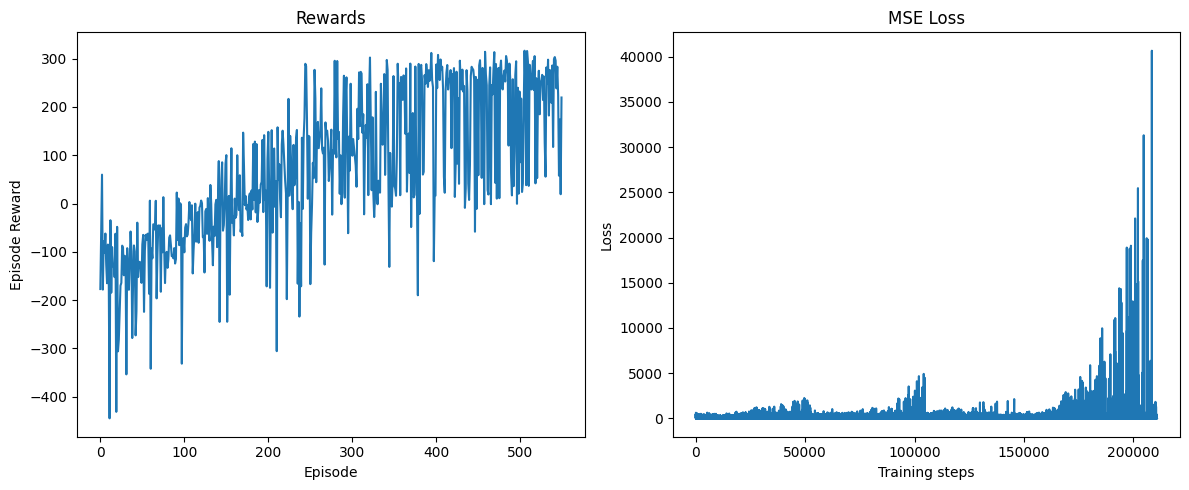

Evaluation returns (greedy): [np.float64(282.9443580011739), np.float64(236.3449435429106), np.float64(258.53915881385535), np.float64(241.3130682391693), np.float64(227.07015265706875)]


In [21]:
## MAIN LOOP ###
total_steps = 0
epsilon = initial_epsilon
episode_rewards = []
losses = []
print_every = 10
best_avg = -1e9

for ep in range(1, num_episodes + 1):
    obs, _ = env.reset()
    state = obs
    done = False
    ep_reward = 0.0
    steps = 0

    while not done and steps < max_steps_per_episode:
        action = epsilon_greedy(state, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated or truncated)

        replay_buffer.append(state, action, reward, next_obs, done)
        state = next_obs
        ep_reward += reward
        steps += 1
        total_steps += 1

        # start training after we have some experiences
        if total_steps > train_after:
            loss_val = train_step(batch_size)
            if loss_val is not None:
                losses.append(loss_val)

        # update target network periodically
        if total_steps % target_update_freq == 0:
            q_target.load_state_dict(q_net.state_dict())

    # end episode
    episode_rewards.append(ep_reward)
    # decay epsilon (exponential)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # logging
    if ep % print_every == 0:
        avg_last100 = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 1 else float('nan')
        avg_last10 = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else float('nan')
        print(f"Ep {ep}/{num_episodes} | EpReward {ep_reward:.2f} | AvgLast10 {avg_last10:.2f} | AvgLast100 {avg_last100:.2f} | Eps {epsilon:.3f} | Replay {len(replay_buffer)}")
        # optional early stop if solved
        if avg_last100 >= 200.0:
            print(f"Solved in {ep} episodes! avg100 = {avg_last100:.2f}")
            break

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("Rewards")

plt.subplot(1,2,2)
plt.plot(losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("MSE Loss")
plt.tight_layout()
plt.show()

def evaluate(n_episodes=5, render=False):
    returns = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_r = 0.0
        while not done:
            action = epsilon_greedy(obs, 0.0)   # greedy
            obs, r, terminated, truncated, _ = env.step(action)
            done = bool(terminated or truncated)
            total_r += r
            if render:
                env.render()
        returns.append(total_r)
    return returns

eval_returns = evaluate(5, render=False)
print("Evaluation returns (greedy):", eval_returns)